In [43]:
%matplotlib inline
import nibabel as nib
from nibabel.processing import resample_to_output
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import re

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report

seed = 42
np.random.seed(seed)  # for reproducibility

In [78]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda0,floatX=float32"
os.environ["KERAS_BACKEND"] = "theano"
import theano
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, MaxPooling3D
from keras.utils import np_utils

In [5]:
# zero-pad some of the entries so they match the filenames
df = pd.read_excel('/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/2018_IA_Hackathon/Factor_Data/comprehension_ability_crystalized_intelligence_with_the_variance_of_g_removed.xlsx',
                   converters={'ID': lambda x: str(x).zfill(4)},
          )
# make the ID the index in the pandas dataframe
df.set_index('ID', inplace=True)
df.head()

Score
ID            
0194  0.280165
0297  0.390203
0318  0.555099
0376 -0.412211
0414 -1.209015

In [17]:
data = []
labels = []
lesion_masks = glob('/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/2018_IA_Hackathon/Factor_Data/All_subs_405_Lesion_Masks/*.nii.gz')
for les_file in lesion_masks:
    match = re.match(r'.*/([0-9]{4}).nii.gz', les_file)
    sub_id = match.groups()[0]
    labels.append(df.loc[sub_id]['Score'])
    les_img = nib.load(les_file)
    les_img_resamp = resample_to_output(les_img, voxel_sizes=(3, 3, 3))
    les_data = les_img_resamp.get_data()
    data.append(les_data)
#     les_data_1d = les_data.reshape(np.prod(les_data.shape))
#     data_collector[sub_id] = les_data #les_data_1d
print(data)

[array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

In [34]:
data_array = np.array(data, dtype="float")
labels_array = np.array(labels, dtype="float")

In [21]:
np.save("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array", data_array)

In [36]:
np.save("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LABELS", labels_array)

In [38]:
data_array = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LM_np_array.npy")
labels_array = np.load("/Dedicated/jmichaelson-wdata/mcrichter/HackUiowa2018/DATA/All_subs_405_LABELS.npy")

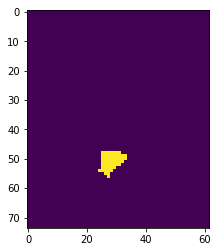

In [39]:
plt.imshow(data_array[0,40,:,:])

In [54]:
X = data_array
y = labels_array

In [73]:
# Normalize the labels
y_normalized = y / np.linalg.norm(y)

(trainX, testX, trainY, testY) = train_test_split(X, y_normalized, test_size=0.1, random_state=seed)


trainX = trainX.reshape(trainX.shape[0], 1, *trainX.shape[1:4])
testX = testX.reshape(testX.shape[0], 1, *testX.shape[1:4])

input_shape = trainX[0].shape

In [93]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv3D, MaxPooling3D
from keras.models import Sequential
import matplotlib.pylab as plt
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping

In [99]:
model = Sequential()
 
model.add(Convolution3D(32, (5,5,5), activation='relu', input_shape=input_shape, data_format = 'channels_first'))
model.add(Convolution3D(32, (5,5,5), activation='relu', input_shape=input_shape, data_format = 'channels_first'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Convolution3D(64, (2,2,2), activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Convolution3D(64, (2,2,2), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))

In [100]:
EPOCHS = 20
BATCH = 50
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])
early_stopper = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')

In [105]:
# 9. Fit model on training data
H = model.fit(trainX, trainY, validation_data=(testX, testY), 
          batch_size=BATCH, nb_epoch=10, verbose=1, callbacks=[early_stopper])

/Users/mcrichter/anaconda3/envs/theano_py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 364 samples, validate on 41 samples
Epoch 1/10
364/364 [==============================] - 7s 20ms/step - loss: 0.0019 - mean_absolute_error: 0.0348 - val_loss: 0.0031 - val_mean_absolute_error: 0.0421
Epoch 2/10
364/364 [==============================] - 7s 20ms/step - loss: 0.0017 - mean_absolute_error: 0.0332 - val_loss: 0.0033 - val_mean_absolute_error: 0.0439
Epoch 3/10
364/364 [==============================] - 7s 20ms/step - loss: 0.0016 - mean_absolute_error: 0.0321 - val_loss: 0.0033 - val_mean_absolute_error: 0.0438
Epoch 4/10
364/364 [==============================] - 7s 20ms/step - loss: 0.0016 - mean_absolute_error: 0.0321 - val_loss: 0.0034 - val_mean_absolute_error: 0.0434
Epoch 5/10
364/364 [==============================] - 7s 20ms/step - loss: 0.0014 - mean_absolute_error: 0.0304 - val_loss: 0.0032 - val_mean_absolute_error: 0.0437
Epoch 6/10
364/364 [==============================] - 7s 20ms/step - loss: 0.0015 - mean_absolute_error: 0.0312 - val_loss: 0.0031

In [88]:
 # 10. Evaluate model on test data
score = model.evaluate(testX, testY, verbose=0)

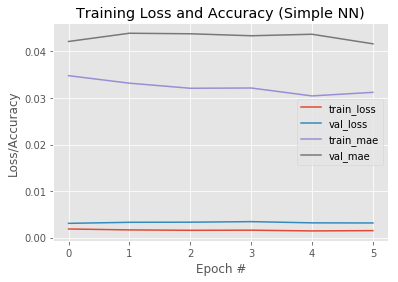

In [106]:
N = np.arange(0, len(H.history["loss"]))
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["mean_absolute_error"], label="train_mae")
plt.plot(N, H.history["val_mean_absolute_error"], label="val_mae")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()